# Attention Mechanism 간단구현

reference: [keras-attention](https://github.com/philipperemy/keras-attention-mechanism)

-----------------

Attention Mechanism이 여러개의 쓰레기값들 중 정답과 실제로 관련이 있는 부분을 잘 찾아내지는 알아보자.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate, LSTM

C:\Users\SHIN-DESKTOP\Anaconda3\envs\KoreaUnivDeep_main\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SHIN-DESKTOP\Anaconda3\envs\KoreaUnivDeep_main\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\SHIN-DESKTOP\Anaconda3\envs\KoreaUnivDeep_main\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\SHIN-DESKTOP\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SHIN-DESKTOP\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future

In [2]:
INPUT_DIM = 100
TIME_STEPS = 20

학습 데이터를 만든다. 입력 데이터는 input_dim까지의 값을 가지며 `n by time_steps` 사이즈의 행렬이다.

In [3]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    # 단위행렬을 섞기 위해 랜덤하게 x를 생성하고 eye와 연산을 하여 '1'의 위치를 랜덤하게 조정
    x = np.random.randint(input_dim, size=(n, time_steps))
    x = np.eye(input_dim)[x]
    # y행렬은 x행렬의 attention 위치
    y = x[:, attention_column, :]
    return x, y

In [4]:
def attention_3d_block(hidden_states):
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    """ >> Inside dense layer
                 hidden_states            dot               W            =>           score_first_part
    (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    W is the trainable weight matrix of attention Luong's multiplicative style score
    """
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    """
               score_first_part           dot        last_hidden_state     => attention_weights
    (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    """
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    """
    (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    """
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [5]:
def get_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    rnn_out = LSTM(32, return_sequences=True)(inputs)
    attention_output = attention_3d_block(rnn_out)
    output = Dense(INPUT_DIM, activation='sigmoid', name='output')(attention_output)
    m = Model(inputs=[inputs], outputs=[output])
    return m

In [6]:
n = 30000
inputs, outputs = get_data_recurrent(n, TIME_STEPS, INPUT_DIM)

In [7]:
simple_attention_model = get_model()
simple_attention_model.summary()
simple_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 100)      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 32)       17024       input_1[0][0]                    
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 20, 32)       1024        lstm[0][0]                       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 32)           0           lstm[0][0]                       
__________________________________________________________________________________________________
attention_

In [8]:
simple_attention_model.fit(x=[inputs], y=outputs, epochs=8, batch_size=64, validation_split=0)

Epoch 1/8
30000/30000 [==============================] - 25s 821us/step - loss: 4.5311 - acc: 0.0224
Epoch 2/8
30000/30000 [==============================] - 21s 699us/step - loss: 4.0276 - acc: 0.0841
Epoch 3/8
30000/30000 [==============================] - 21s 692us/step - loss: 2.1003 - acc: 0.5905
Epoch 4/8
30000/30000 [==============================] - 21s 696us/step - loss: 0.2837 - acc: 0.9987
Epoch 5/8
30000/30000 [==============================] - 21s 703us/step - loss: 0.0642 - acc: 1.0000
Epoch 6/8
30000/30000 [==============================] - 21s 702us/step - loss: 0.0294 - acc: 1.0000
Epoch 7/8
30000/30000 [==============================] - 21s 691us/step - loss: 0.0169 - acc: 1.0000
Epoch 8/8
30000/30000 [==============================] - 21s 686us/step - loss: 0.0107 - acc: 1.0000


In [10]:
# Test
test_x, test_y = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
result = simple_attention_model.evaluate(test_x, test_y, batch_size=64, verbose=0)
print("Loss:", result[0])
print("Accuracy:", result[1])

Loss: 0.006157661322504282
Accuracy: 1.0


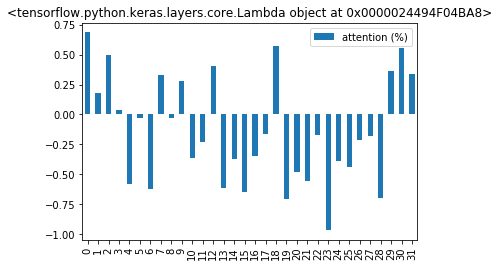

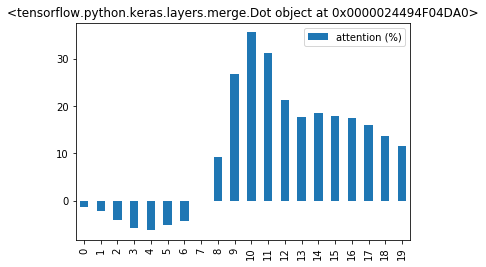

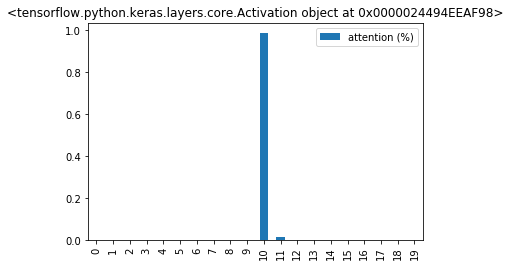

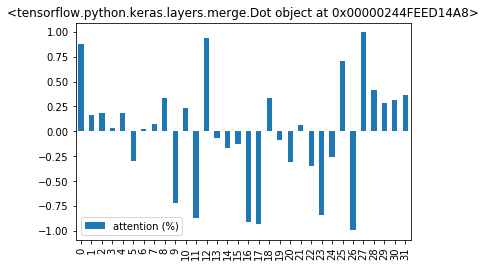

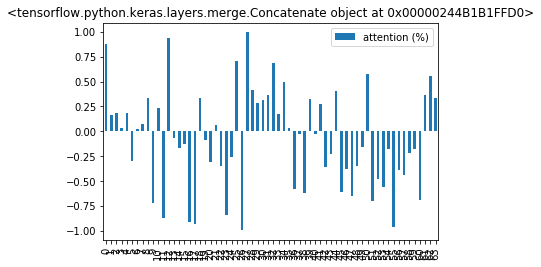

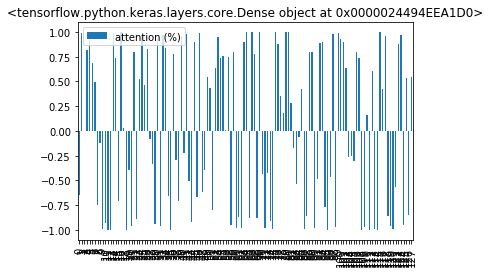

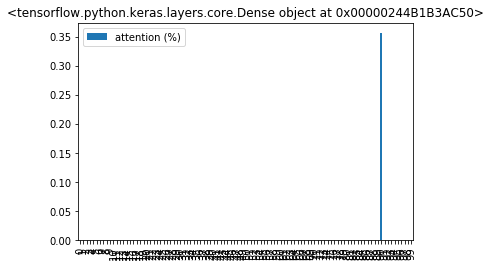

In [19]:
import tensorflow.keras
from tensorflow.keras import backend as K

# Get attention vector
for i in range(3, len(simple_attention_model.layers)):
    attention_layer = simple_attention_model.layers[i]
    func = K.function([simple_attention_model.input] + [K.learning_phase()], [attention_layer.output])
    output = func([test_x, 1.0])[0]
    attention_vector = np.mean(output, axis=0)
    # Show attention vector
    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar', title=simple_attention_model.layers[i])
    plt.show()

## what if no attention?
-----

In [32]:
def get_model_without_attention():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    rnn_out = LSTM(32, return_sequences=True)(inputs)
    #attention_output = attention_3d_block(rnn_out)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(20,), name='hidden_state')(rnn_out)
    output = Dense(INPUT_DIM, activation='sigmoid', name='output')(h_t)
    m = Model(inputs=[inputs], outputs=[output])
    return m

n = 30000
inputs, outputs = get_data_recurrent(n, TIME_STEPS, INPUT_DIM)

no_attention_model = get_model_without_attention()
no_attention_model.summary()
no_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
no_attention_model.fit(x=[inputs], y=outputs, epochs=8, batch_size=64, validation_split=0)

# Test
test_x, test_y = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
result = no_attention_model.evaluate(test_x, test_y, batch_size=64, verbose=0)
print("Loss:", result[0])
print("Accuracy:", result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 20, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 32)            17024     
_________________________________________________________________
hidden_state (Lambda)        (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 100)               3300      
Total params: 20,324
Trainable params: 20,324
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
30000/30000 [==============================] - 20s 672us/step - loss: 4.5799 - acc: 0.0149
Epoch 2/8
30000/30000 [==============================] - 19s 625us/step - loss: 4.3747 - acc: 0.0418
Epoch 3/8
30000/30000 [==============================] - 20s 653us/s

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000002449EC50E80>>
Traceback (most recent call last):
  File "C:\Users\SHIN-DESKTOP\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\client\session.py", line 1467, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\SHIN-DESKTOP\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 2494531698760


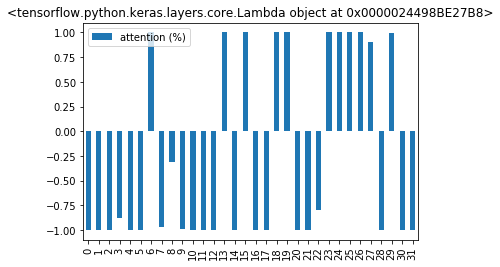

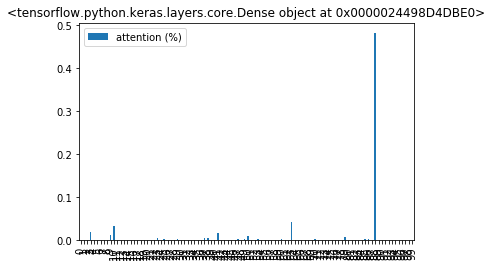

In [40]:
# Get attention vector
for i in range(2, len(no_attention_model.layers)):
    attention_layer = no_attention_model.layers[i]
    func = K.function([no_attention_model.input] + [K.learning_phase()], [attention_layer.output])
    output = func([test_x, 1.0])[0]
    attention_vector = np.mean(output, axis=0)
    # Show attention vector
    pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar', title=no_attention_model.layers[i])
    plt.show()